# Regression Model

### Importing Libraries

In [2]:
from Dataset import MyDataset
import torch
import torch.nn as nn
import torchvision.transforms as transforms

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# import os
# os.chdir("drive/MyDrive/DL_Project")

In [3]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Implementing Model

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(8)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(8*1000*750,64)
        self.fc2 = nn.Linear(64,1)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = x.view(-1,8*1000*750)

        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model=CNN()
model.to(device)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6000000, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

### Setting Hyperparameters

In [5]:
num_epochs=10
batch_size=8
learning_rate=0.000001

### Defining Loss Function and Optimizer

In [6]:
criterion=nn.MSELoss()
optimizer=torch.optim.AdamW(model.parameters(),lr=learning_rate)

### Training & Validating Model

In [7]:
transform = transforms.Compose([
    transforms.Resize((2000, 1500)),
    transforms.ToTensor()
])

In [8]:
train_dataset=MyDataset("Data/train_set.csv",transform=transform)
train_dataloader=torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)

In [9]:
valid_dataset=MyDataset("Data/validation_set.csv",transform=transform)
valid_dataloader=torch.utils.data.DataLoader(valid_dataset,batch_size=batch_size,shuffle=True)

In [10]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for i, (images, target) in enumerate(train_dataloader):
        images = images.reshape(-1,3,2000,1500).to(device)
        target = target.to(device)

        optimizer.zero_grad()

        output = model(images)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Performing validation
    model.eval()
    with torch.no_grad():
        val_loss = 0.0

        for i, (val_images, val_target) in enumerate(valid_dataloader):
            val_images = val_images.reshape(-1,3,2000,1500).to(device)
            val_target = val_target.to(device)

            val_output = model(val_images)
            val_loss += criterion(val_output, val_target).item()

            average_val_loss = val_loss / len(valid_dataloader)

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss:.4f}, Validation Loss: {average_val_loss:.4f}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/10], Training Loss: 1.5395, Validation Loss: 1.6796
Epoch [2/10], Training Loss: 2.7133, Validation Loss: 1.3627
Epoch [3/10], Training Loss: 3.4458, Validation Loss: 1.3839
Epoch [4/10], Training Loss: 3.2708, Validation Loss: 1.4699
Epoch [5/10], Training Loss: 1.6735, Validation Loss: 1.4185
Epoch [6/10], Training Loss: 2.9403, Validation Loss: 1.3765
Epoch [7/10], Training Loss: 2.0593, Validation Loss: 1.3753
Epoch [8/10], Training Loss: 2.8495, Validation Loss: 1.4124


KeyboardInterrupt: ignored

### Saving Model Weights

In [11]:
torch.save(model.state_dict(), 'model_weights.pth')

In [ ]:
model.load_state_dict(torch.load('model_weights.pth'))

### Testing Model

In [12]:
test_dataset=MyDataset("Data/test_set.csv",transform=transform)
test_dataloader=torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

In [13]:
model.eval()
with torch.no_grad():
    test_loss = 0.0

    for i, (test_images, test_target) in enumerate(test_dataloader):
        test_images = test_images.reshape(-1,3,2000,1500).to(device)
        test_target = test_target.to(device)

        test_output = model(test_images)
        test_loss += criterion(test_output, test_target).item()

        average_test_loss = test_loss / len(test_dataloader)

    print(f'Average Loss: {average_test_loss}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Average Loss: 1.5964326624359404


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


### Sample Output

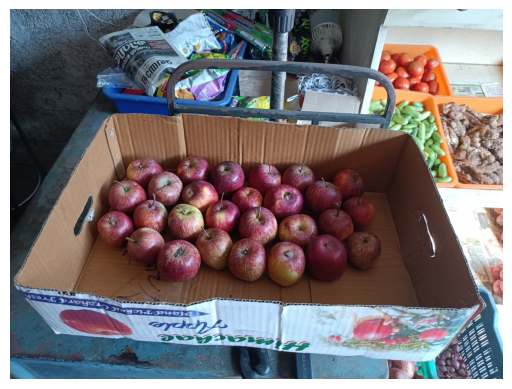

In [16]:
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt

img = Image.open('Data/FruitBox/Image_148.jpg')

plt.imshow(img)
plt.axis('off')
plt.show()

In [21]:
img = transform(Image.open(os.path.join("Data","FruitBox/Image_148.jpg")).convert("RGB"))
target = torch.tensor(2.71)

test_images = img.reshape(-1,3,2000,1500).to(device)
test_target = target.to(device)
test_output = model(test_images)

print(f'Predicted output : {test_output.item()} , Actual : {2.71}')

Predicted output : 1.790505051612854 , Actual : 2.71
